In [3]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, \
    GlobalMaxPooling1D, Embedding, TextVectorization, Conv1D, Flatten, Input, MaxPooling1D
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Get the Data

In [5]:

train_data, test_data = tfds.load(
    'ag_news_subset',
    split=['train', 'test'],
    batch_size=-1
)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Decode bytes to strings
df_train['description'] = df_train['description'].apply(lambda x: x.decode('utf-8'))
df_test['description'] = df_test['description'].apply(lambda x: x.decode('utf-8'))
df_train['title'] = df_train['title'].apply(lambda x: x.decode('utf-8'))
df_test['title'] = df_test['title'].apply(lambda x: x.decode('utf-8'))

print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")

2025-12-07 23:23:36.016169: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Train size: 120000, Test size: 7600


In [7]:
# Ensure text columns are proper strings, not bytes
for df in [df_train, df_test]:
    for col in ["title", "description"]:
        if isinstance(df[col].iloc[0], bytes):
            df[col] = df[col].apply(lambda x: x.decode("utf-8"))
        else:
            df[col] = df[col].astype(str)

# 0=World, 1=Sports, 2=Business, 3=Sci/Tech
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
df_train["label_name"] = df_train["label"].map(label_map)
df_test["label_name"]  = df_test["label"].map(label_map)

df_train[["label", "label_name", "title", "description"]].head()

,label,label_name,title,description
0,3,Sci/Tech,AMD Debuts Dual-Core Opteron Processor,AMD #39;s new dual-core Opteron chip is design...
1,1,Sports,Wood's Suspension Upheld (Reuters),Reuters - Major League Baseball\Monday announc...
2,2,Business,Bush reform may have blue states seeing red,President Bush #39;s quot;revenue-neutral quo...
3,3,Sci/Tech,'Halt science decline in schools',Britain will run out of leading scientists unl...
4,1,Sports,Gerrard leaves practice,"London, England (Sports Network) - England mid..."


# Exploratory Data Analysis

## 1. Data Structure and Basic Info

Here we inspect the overall structure of the dataset before any filtering. We look at column types, non-null counts, and a few example rows to confirm that the data loaded as expected.



In [9]:
# Sanity check/sample info

print("Train info:")
df_train.info()
print("\nTest info:")
df_test.info()

df_train.sample(5, random_state=1842)[["label_name", "title", "description"]]

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  120000 non-null  object
 1   label        120000 non-null  int64 
 2   title        120000 non-null  object
 3   label_name   120000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.7+ MB

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  7600 non-null   object
 1   label        7600 non-null   int64 
 2   title        7600 non-null   object
 3   label_name   7600 non-null   object
dtypes: int64(1), object(3)
memory usage: 237.6+ KB


,label_name,title,description
28917,World,Activists' tool for change in Iran:,TEHRAN -- A new movement of passive resistance...
59051,Business,"Stocks Off, Higher Oil Stirs Profit Worry",NEW YORK (Reuters) - U.S. stocks were a littl...
54620,Sports,Notes: Guillen case settled,Suspended Angels outfielder Jose Guillen #39;s...
62931,Sci/Tech,Security firm hires teenage Sasser virus writer,"Sven Jaschan, an 18-year-old from Waffensen in..."
101434,Business,Safety critic says he faces FDA transfer in q...,"Dr. David Graham, the Food and Drug Administra..."


The AG News dataset loads cleanly with 120,000 training rows and 7,600 test rows, and all text fields are complete with no missing values. A quick sample confirms that titles, descriptions, and mapped label names look correct, so the data is ready for filtering and analysis.

## 2. Class Distribution (All 4 Categories)

Before focusing on Sports vs Business, we briefly look at the original 4-class distribution in the AG News dataset. This helps motivate our choice of binary classes and confirms that the dataset is reasonably balanced.



Train class counts:
 label_name
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64

Test class counts:
 label_name
Business    1900
Sci/Tech    1900
Sports      1900
World       1900
Name: count, dtype: int64


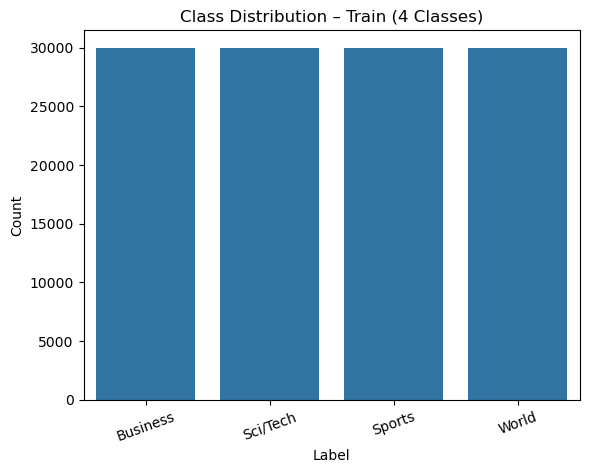

In [11]:
train_counts = df_train["label_name"].value_counts().sort_index()
test_counts  = df_test["label_name"].value_counts().sort_index()

print("Train class counts:\n", train_counts)
print("\nTest class counts:\n", test_counts)

plt.figure()
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.title("Class Distribution – Train (4 Classes)")
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(rotation=20)
plt.show()

As anticipated, the full AG News dataset is perfectly balanced across the four original categories, with 30,000 training examples per class and 1,900 test examples per class. This confirms that the dataset is well-structured and that filtering down to Sports vs Business will still leave us with a balanced binary classification problem.



## 3. Split Sports vs Business + Sci/Tech + World

Our project focuses on a binary classification task: routing news articles to either the Sports or Business editorial teams.

Here we:

Filter the dataset to only Sports and Business articles.
Create a binary target variable (target), where Sports = 1, Business + Sci/Tech + World = 0.
Combine title and description into a single text field for later modeling.

In [13]:
print("\n" + "="*80)
print("SELECTED GROUPING: [Sports] vs [Business + Sci/Tech + World]")
print("="*80)

# Group 1: Sports (1) = label 0
# Group 2: World(0) + Business (2) + Sci/Tech (3) = label 1
df_train_filtered = df_train.copy()
df_test_filtered = df_test.copy()

df_train_filtered['target'] = df_train_filtered['label'].apply(
    lambda x: 0 if x == 1 else 1
)
df_test_filtered['target'] = df_test_filtered['label'].apply(
    lambda x: 0 if x == 1 else 1
)

df_train_filtered["text_all"] = df_train_filtered["title"] + " " + df_train_filtered["description"]
df_test_filtered["text_all"] = df_test_filtered["title"] + " " + df_test_filtered["description"]


print("\nSports vs Business + Sci/Tech + World class counts:")
print("\nTrain data: ")
print(df_train_filtered["label_name"].value_counts())
print("\nTest data: ")
print(df_test_filtered["label_name"].value_counts())


print("\nSample data:")
print(df_train_filtered[["label_name", "title", "description"]].head())


SELECTED GROUPING: [Sports] vs [Business + Sci/Tech + World]

Sports vs Business + Sci/Tech + World class counts:

Train data: 
label_name
Sci/Tech    30000
Sports      30000
Business    30000
World       30000
Name: count, dtype: int64

Test data: 
label_name
Sports      1900
World       1900
Sci/Tech    1900
Business    1900
Name: count, dtype: int64

Sample data:
  label_name                                        title  \
0   Sci/Tech       AMD Debuts Dual-Core Opteron Processor   
1     Sports           Wood's Suspension Upheld (Reuters)   
2   Business  Bush reform may have blue states seeing red   
3   Sci/Tech            'Halt science decline in schools'   
4     Sports                      Gerrard leaves practice   

                                         description  
0  AMD #39;s new dual-core Opteron chip is design...  
1  Reuters - Major League Baseball\Monday announc...  
2  President Bush #39;s  quot;revenue-neutral quo...  
3  Britain will run out of leading scientis

Now that we have split the dataset to Sports vs Business + Sci/Tech + World articles, we created a balanced binary subset with 30,000 examples in each class. Titles and descriptions are combined into a single text field (text_all), which will later serve as the input for vectorization and modeling.



## 4. Text Characteristics

We next explore basic text characteristics for titles and descriptions, such as:

Length in characters and words.
How these lengths differ across Sports vs Business articles.
This helps us understand the scale of the text data and whether length-based features might be informative.

In [15]:
# Length in characters then in words
df_train_filtered["title_char_len"] = df_train_filtered["title"].str.len()
df_train_filtered["desc_char_len"]  = df_train_filtered["description"].str.len()
df_train_filtered["title_word_len"] = df_train_filtered["title"].str.split().str.len()
df_train_filtered["desc_word_len"]  = df_train_filtered["description"].str.split().str.len()

length_cols = ["title_char_len", "desc_char_len", "title_word_len", "desc_word_len"]

df_train_filtered[length_cols].describe()

,title_char_len,desc_char_len,title_word_len,desc_word_len
count,120000.000000,120000.000000,120000.000000,120000.000000
mean,42.075508,193.402017,6.784758,31.062692
std,13.563871,64.452006,2.087255,9.757035
min,6.000000,20.000000,1.000000,3.000000
25%,33.000000,155.000000,5.000000,25.000000
50%,41.000000,188.000000,7.000000,30.000000
75%,49.000000,219.000000,8.000000,36.000000
max,115.000000,985.000000,19.000000,173.000000


Titles are very short (about 60 characters and 6–7 words on average), while descriptions are much longer (around 190 characters and 30 words), confirming that most of the useful information comes from the description text. There’s wide variability in description length, but overall the text is consistent with typical news formatting and suitable for modeling.

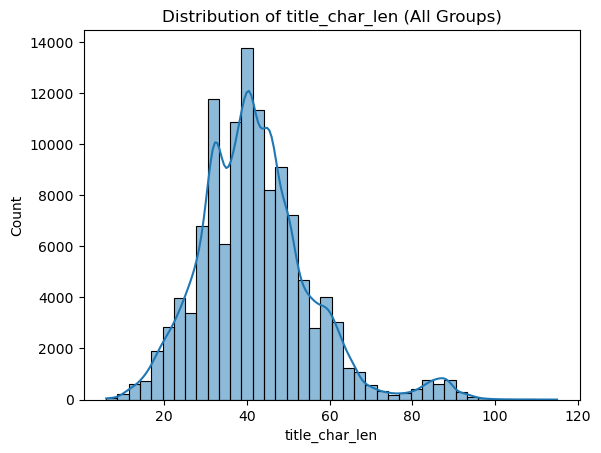

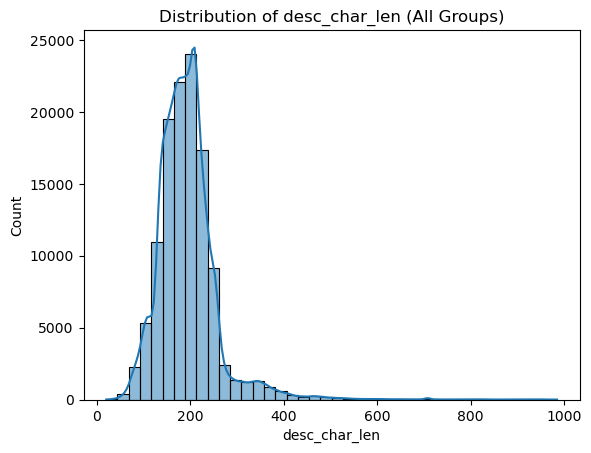

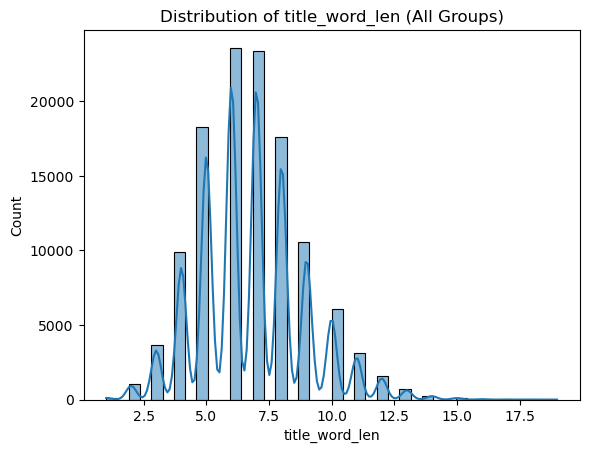

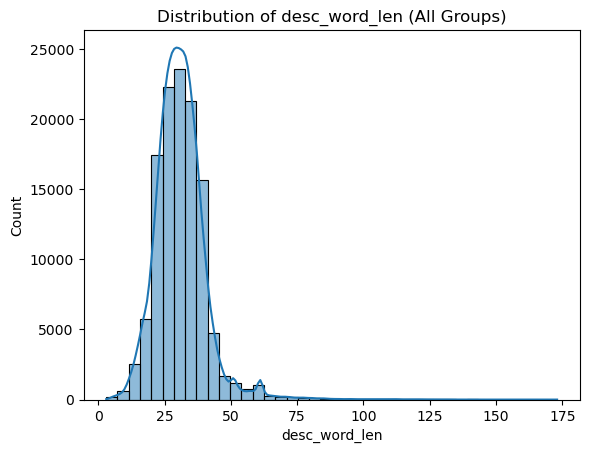

In [17]:
for col in length_cols:
    plt.figure()
    sns.histplot(df_train_filtered[col], bins=40, kde=True)
    plt.title(f"Distribution of {col} (All Groups)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

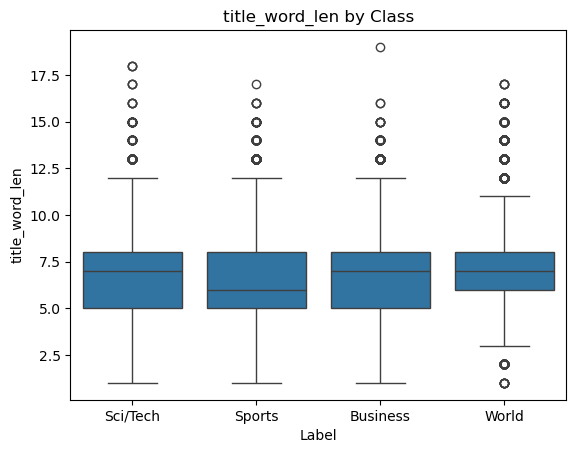

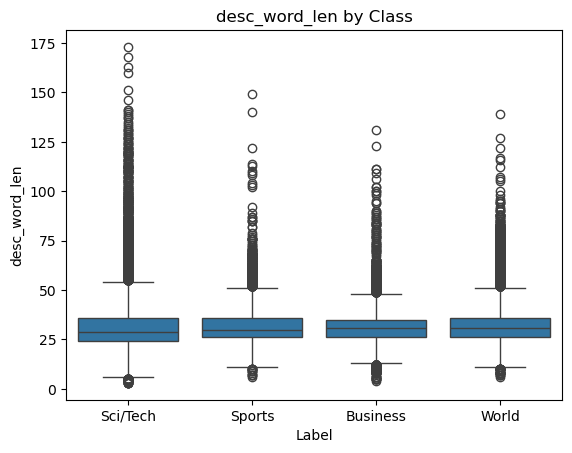

In [19]:
for col in ["title_word_len", "desc_word_len"]:
    plt.figure()
    sns.boxplot(data=df_train_filtered, x="label_name", y=col)
    plt.title(f"{col} by Class")
    plt.xlabel("Label")
    plt.ylabel(col)
    plt.show()

Title and description lengths look very similar across Sports and Business articles, with nearly identical medians and distributions in both categories. This indicates that simple length-based features don’t meaningfully distinguish the two classes, reinforcing the need for vocabulary-based text analysis rather than structural features alone.



## 5. Correlations Between Numeric Features

Finally, we look at correlations between simple numeric features such as:

Title/description length in characters.
Title/description length in words.
The binary label.
This shows how strongly these length-based features relate to one another and whether they appear to be informative for classification.

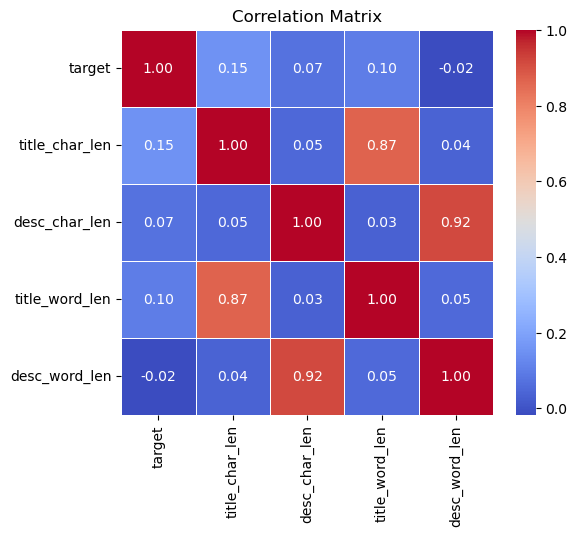

In [21]:
corr_cols = ["target", "title_char_len", "desc_char_len", "title_word_len", "desc_word_len"]
corr = df_train_filtered[corr_cols].corr()
corr

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The length-based features are highly correlated with each other—for example, character and word counts within titles or descriptions are almost perfectly aligned—but they show near-zero correlation with the target label. This confirms that simple text length does not meaningfully differentiate Sports from Business articles, reinforcing the need for vocabulary-driven features like TF-IDF or learned embeddings.

## 6. Most Common Words (Sports vs Business + Sci/Tech + World)

To dive into the vocabulary differences between our two groups, we can observe the most common words that appear in each set. Comparing the most common vocabulary used in the two groups gives us a surface level indication of whether there will be much overlap, which in turn dictates how successful our model will be. 


Dataset sizes:
Train: 120000 (Sports: 30000, Other (World+Business+Sci/Tech): 90000)
Test: 7600 (Sports: 1900, Other (World+Business+Sci/Tech): 5700)

EXPLORATORY DATA ANALYSIS - Top Words by Group

Top 15 words in GROUP 1 [Sports]:
  game           :  4281
  new            :  4163
  season         :  3647
  team           :  3492
  win            :  3491
  night          :  3087
  world          :  3014
  cup            :  2762
  league         :  2761
  year           :  2679
  victory        :  2657
  sunday         :  2537
  quot           :  2321
  coach          :  2319
  time           :  2187

Top 15 words in GROUP 2 [World + Business + Sci/Tech]:
  said           : 18761
  reuters        : 17659
  new            : 17264
  company        :  7568
  oil            :  7542
  quot           :  7275
  year           :  7093
  iraq           :  6303
  monday         :  6063
  tuesday        :  5996
  microsoft      :  5936
  wednesday      :  5889
  thursday       :  5869
  presiden

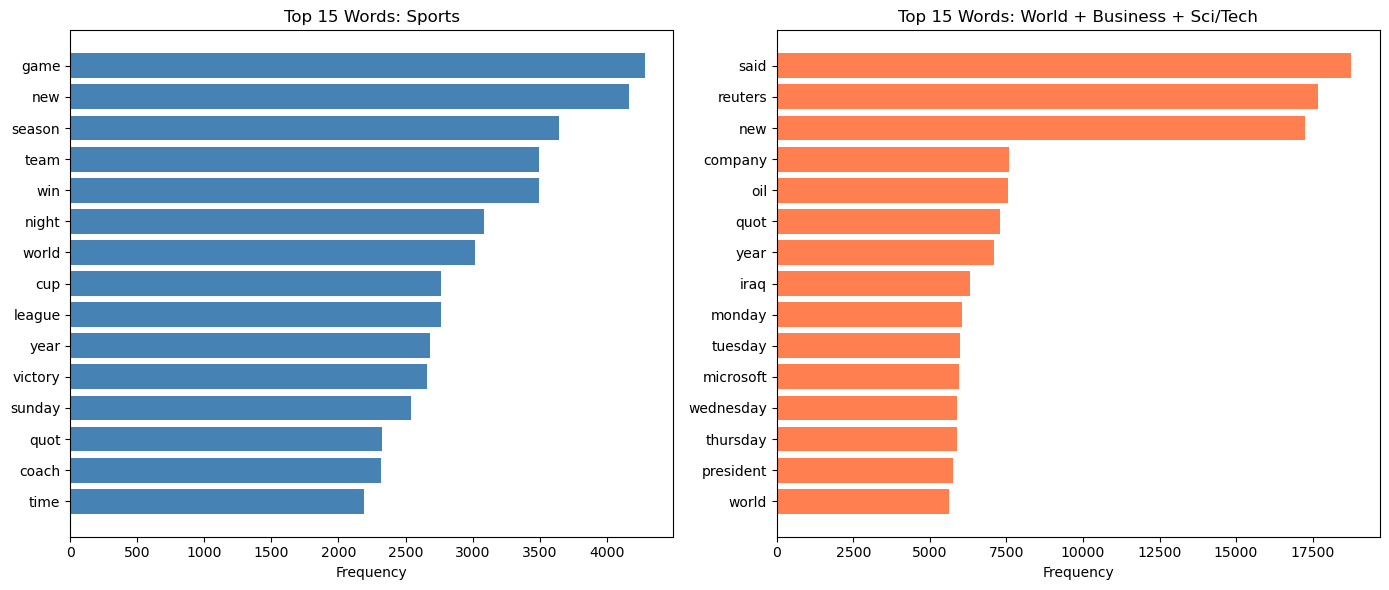

In [23]:
def get_top_words(texts, n=20, stopwords=None):
    """Extract top n words from texts"""
    all_words = []
    for text in texts:
        words = re.findall(r'\b[a-z]{3,}\b', text.lower())
        all_words.extend(words)
    
    # Remove basic stop words from sklearn's stopwords
    all_words = [w for w in all_words if w not in ENGLISH_STOP_WORDS]
    
    return Counter(all_words).most_common(n)

print(f"\nDataset sizes:")
print(f"Train: {len(df_train_filtered)} (Sports: {sum(df_train_filtered['target']==0)}, "
      f"Other (World+Business+Sci/Tech): {sum(df_train_filtered['target']==1)})")
print(f"Test: {len(df_test_filtered)} (Sports: {sum(df_test_filtered['target']==0)}, "
      f"Other (World+Business+Sci/Tech): {sum(df_test_filtered['target']==1)})")


print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS - Top Words by Group")
print("="*80)

group1_words = get_top_words(
    df_train_filtered[df_train_filtered['target']==0]['text_all']
)
group2_words = get_top_words(
    df_train_filtered[df_train_filtered['target']==1]['text_all']
)

print(f"\nTop 15 words in GROUP 1 [Sports]:")
for word, count in group1_words[:15]:
    print(f"  {word:15s}: {count:5d}")

print(f"\nTop 15 words in GROUP 2 [World + Business + Sci/Tech]:")
for word, count in group2_words[:15]:
    print(f"  {word:15s}: {count:5d}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

words_g1, counts_g1 = zip(*group1_words[:15])
words_g2, counts_g2 = zip(*group2_words[:15])

axes[0].barh(range(15), counts_g1, color='steelblue')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(words_g1)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words: Sports')

axes[1].barh(range(15), counts_g2, color='coral')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(words_g2)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words: World + Business + Sci/Tech')

plt.tight_layout()
plt.show()

The top 15 words in each group seems to be quite different, which indicates there may not be much overlap in vocabulary. Digging further, we can run an analysis on the top N words from each group, and identify what percentage overlap.

## 7. Overlap Analysis

In [25]:
# Extract top 50 words from each group
top_n = 50
top_words_1 = set([word for word, count in group1_words[:top_n]])
top_words_2 = set([word for word, count in group2_words[:top_n]])

# Find overlap and unique words
overlap = top_words_1 & top_words_2
group1_unique = top_words_1 - top_words_2
group2_unique = top_words_2 - top_words_1

print(f"Overlap Analysis (Top 50 words):")
print(f"Sports unique words: {len(group1_unique)} ({100*len(group1_unique)/top_n:.1f}%)")
print(f"Other unique words: {len(group2_unique)} ({100*len(group2_unique)/top_n:.1f}%)")
print(f"Overlapping words: {len(overlap)} ({100*len(overlap)/top_n:.1f}%)")
print(f"\nOverlapping words: {', '.join(sorted(overlap))}")

# Check word appearance in titles
g1_topwords_in_titles = df_train_filtered[df_train_filtered['target']==0]['title'].str.lower()
g2_topwords_in_titles = df_train_filtered[df_train_filtered['target']==1]['title'].str.lower()

group1_top_unique = [w for w, c in group1_words[:30] if w not in overlap][:15]
group2_top_unique = [w for w, c in group2_words[:30] if w not in overlap][:15]

group1_pattern = '|'.join(group1_top_unique)
group2_pattern = '|'.join(group2_top_unique)

group1_title_indicators = sum(g1_topwords_in_titles.str.contains(group1_pattern, regex=True, na=False))
group2_title_indicators = sum(g2_topwords_in_titles.str.contains(group2_pattern, regex=True, na=False))

g1_in_g2_titles = sum(g2_topwords_in_titles.str.contains(group1_pattern, regex=True, na=False))
g2_in_g1_titles = sum(g1_topwords_in_titles.str.contains(group2_pattern, regex=True, na=False))

print(f"\nTitle keyword analysis:")
print(f"Sports words in Sports titles: {100*group1_title_indicators/len(g1_topwords_in_titles):.1f}%")
print(f"Other words in Other titles: {100*group2_title_indicators/len(g2_topwords_in_titles):.1f}%")
print(f"\nCross-contamination: \nSports in Other (World+Business+Sci/Tech): {100*g1_in_g2_titles/len(g2_topwords_in_titles):.1f}%")
print(f"Other (World+Business+Sci/Tech) in Sports: {100*g2_in_g1_titles/len(g1_topwords_in_titles):.1f}%")


print(f"\n{len(overlap)}/{top_n} of top words overlap between groups")

Overlap Analysis (Top 50 words):
Sports unique words: 16 (32.0%)
Other unique words: 16 (32.0%)
Overlapping words: 4 (8.0%)

Overlapping words: new, quot, world, year

Title keyword analysis:
Sports words in Sports titles: 25.0%
Other words in Other titles: 16.1%

Cross-contamination: 
Sports in Other (World+Business+Sci/Tech): 6.8%
Other (World+Business+Sci/Tech) in Sports: 2.0%

4/50 of top words overlap between groups


Only 4 out of the top 50 words overlap between the two groups, which suggests that there is minimal overlap! This two group split looks promising as we move onto our models.

# Preprocessing

For preprocessing, I represented the documents using a TF–IDF vectorizer with English stop-word removal and both unigrams and bigrams, keeping only the top 5,000 features to keep the vocabulary size manageable. I set min_df=3 and max_df=0.8 to drop extremely rare and overly common terms, which reduces noise and improves generalization. 

The resulting TF–IDF matrix is high-dimensional and sparse, so I applied Truncated SVD to reduce it down to 300 latent dimensions. The number of components (300) was chosen based on the cumulative explained variance curve, which showed that this value captures a substantial proportion of the variance while avoiding an unnecessarily large feature space.


TF-IDF vectorization...
TF-IDF shape: (120000, 5000)
Sparsity: 99.6%

Truncated SVD (Dimension Reduction)...
Reduced to 300 dimensions
Explained variance: 29.7%


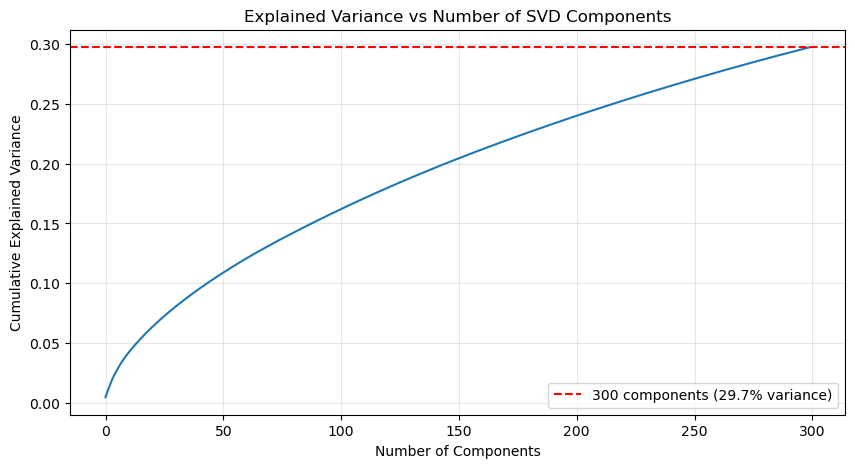

In [27]:
# Create TF-IDF vectorizer
print("\nTF-IDF vectorization...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(df_train_filtered['text_all'])
X_test_tfidf = tfidf.transform(df_test_filtered['text_all'])

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Sparsity: {100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.1f}%")

# Dimension reduction
print("\nTruncated SVD (Dimension Reduction)...")
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

explained_var = svd.explained_variance_ratio_.sum()
print(f"Reduced to {X_train_svd.shape[1]} dimensions")
print(f"Explained variance: {100*explained_var:.1f}%")

# Explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of SVD Components')
plt.axhline(y=explained_var, color='r', linestyle='--', 
            label=f'{300} components ({100*explained_var:.1f}% variance)')
plt.legend()
plt.grid(True, alpha=0.3)

y_train = df_train_filtered['target'].values
y_test = df_test_filtered['target'].values


# Model the Data: Initial Models

## Random Forest

For our baseline model, we chose a Random Forest classifier. Random Forests perform well in this scenario as they can handle nonlinear relationships and interactions without much tuning, and are relatively robust to noisy inputs. The disadvantage is that they don’t  understand phrase structure, since they only see the compressed numeric features. They also can get a bit heavy in memory and training time with many trees, so we kept the setup pretty simple with 100 trees and default depth. To gauge its performance, we measured the test accuracy and the classification report, an indication of how much room there was for a deep model to improve.

In [29]:
print("\nRandom Forest baseline model...")


model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_svd, y_train)


y_pred_train = model.predict(X_train_svd)
y_pred_test = model.predict(X_test_svd)


train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nAccuracy:")
print(f"  Training:   {train_acc:.4f} ({100*train_acc:.2f}%)")
print(f"  Testing:    {test_acc:.4f} ({100*test_acc:.2f}%)")
print(f"  Overfitting: {train_acc - test_acc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, 
                            target_names=['Sports', 'Business + Sci/Tech + World'],
                            digits=4))


results = {
    'Random Forest': {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'model': model,
        'predictions': y_pred_test
    }
}


Random Forest baseline model...

Accuracy:
  Training:   1.0000 (100.00%)
  Testing:    0.9628 (96.28%)
  Overfitting: 0.0372

Classification Report:
                             precision    recall  f1-score   support

                     Sports     0.9524    0.8958    0.9232      1900
Business + Sci/Tech + World     0.9659    0.9851    0.9754      5700

                   accuracy                         0.9628      7600
                  macro avg     0.9592    0.9404    0.9493      7600
               weighted avg     0.9626    0.9628    0.9624      7600



# Model the Data: Deep Learning

## Convolutional Neural Network

For the deep learning model, we went with a 1D CNN, using an embedding layer followed by a convolution, global max pooling, and a few dense layers with dropout. 

We chose CNN here as it can pick up local patterns like key phrases while being much faster to train than a RNN on large datasets. Compared to the Random Forest, the CNN has the advantage of working on sequences, but it’s more computationally expensive. We tuned the vocabulary size (10,000), max sequence length (200), embedding size (100), number of filters (128), and dropout rates by watching validation accuracy/loss and using early stopping with a patience of 3 to avoid overfitting. Overall, our optimization strategy was to start with a standard CNN text architecture, adjust a few key parameters, and rely on the final test metrics to decide what to keep.

In [31]:
# Hyperparameters
MAX_WORDS = 10000  
MAX_LEN = 200  
EMBEDDING_DIM = 100

# Tokenization
print("\nTokenizing text...")
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train_filtered['text_all'])


X_train_seq = tokenizer.texts_to_sequences(df_train_filtered['text_all'])
X_test_seq = tokenizer.texts_to_sequences(df_test_filtered['text_all'])


X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Tokenized data shape: {X_train_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)} words")

# CNN model
print("\nBuilding CNN architecture...")

cnn_model = Sequential()
cnn_model.add(Input(shape=(MAX_LEN,))) 
cnn_model.add(Embedding(
    input_dim=MAX_WORDS,
    output_dim=EMBEDDING_DIM
))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nCNN Model Architecture:")
cnn_model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)



history = cnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate CNN
print("\nEvaluating CNN on test set...")
test_loss, test_acc_cnn = cnn_model.evaluate(X_test_pad, y_test, verbose=0)

# Predictions
y_pred_cnn_prob = cnn_model.predict(X_test_pad, verbose=0)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

print(f"\nCNN Results:")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc_cnn:.4f} ({100*test_acc_cnn:.2f}%)")

print(f"\nClassification Report (CNN):")
print(classification_report(y_test, y_pred_cnn, 
                            target_names=['Sports', 'Business + Sci/Tech + World'],
                            digits=4))



Tokenizing text...
Tokenized data shape: (120000, 200)
Vocabulary size: 70345 words

Building CNN architecture...

CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,361 (4.06 MB)

 Trainable params: 1,063,361 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9525 - loss: 0.1230 - val_accuracy: 0.9822 - val_loss: 0.0554
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9890 - loss: 0.0376 - val_accuracy: 0.9819 - val_loss: 0.0532
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9935 - loss: 0.0189 - val_accuracy: 0.9823 - val_loss: 0.0670
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9832 - val_loss: 0.0749
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9829 - val_loss: 0.0998
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Evaluating CNN on test set...

CNN Results:
  Test Loss:     0.0567
  Test Accuracy: 0.9818 (98.18%)

Classification Report (CNN):
                             precision    recall  f1-score   support

                     Sports     0.9632    0.9642    0.9637      1

# Model Evaluation

Our final step is to evaluate our deep learning model (CNN), and compare with our baseline model (Random Forest). To visualize our findings, we plot accuracy and loss metrics, as well as confusion matrixes.


CNN MODEL ANALYSIS


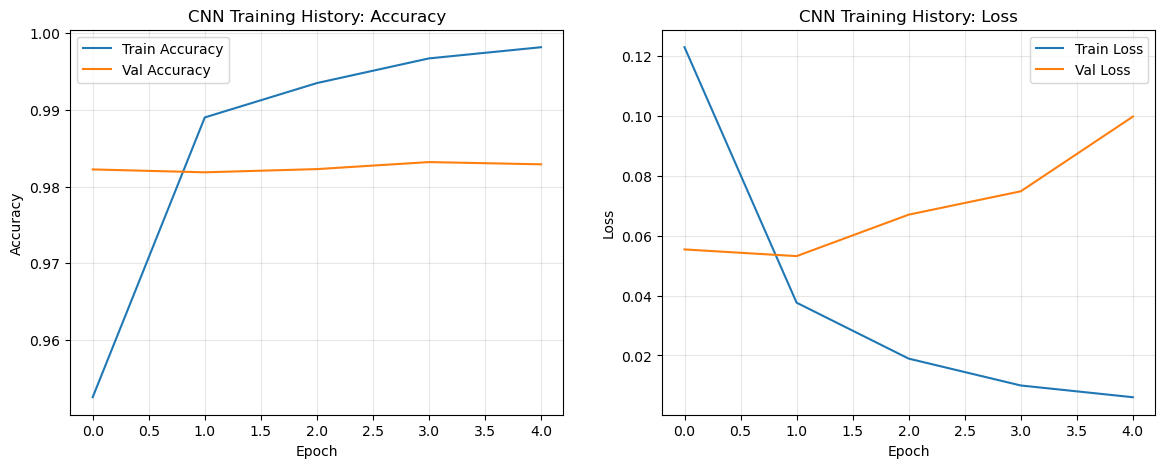

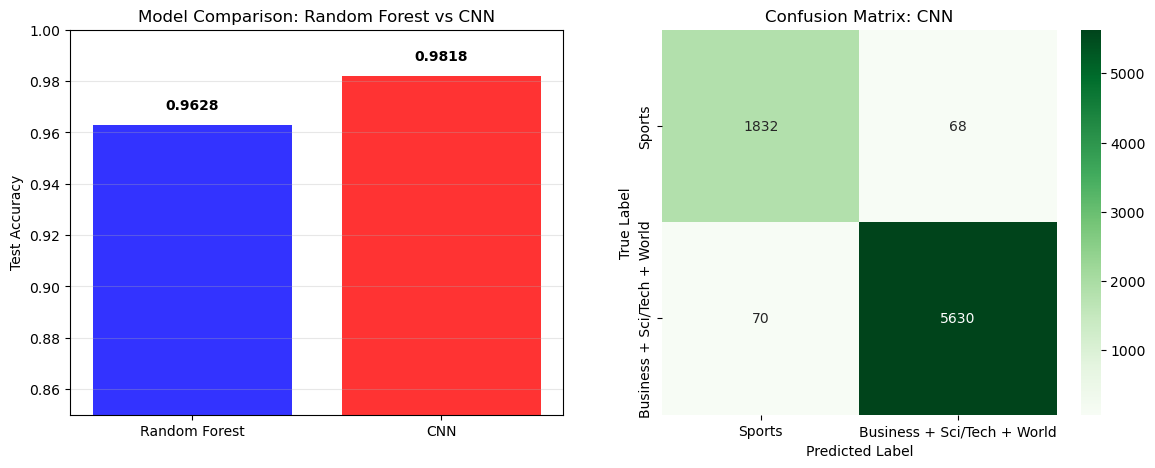

In [33]:

# Plot training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('CNN Training History: Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('CNN Training History: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Confusion matrix for CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compare RF vs CNN
models_comparison = ['Random Forest', 'CNN']
accuracies_comparison = [test_acc, test_acc_cnn]
colors = ['blue', 'red']

axes[0].bar(models_comparison, accuracies_comparison, color=colors, alpha=0.8)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Model Comparison: Random Forest vs CNN')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')
for i, (model_name, acc) in enumerate(zip(models_comparison, accuracies_comparison)):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')


cm_cnn = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Sports', 'Business + Sci/Tech + World'],
            yticklabels=['Sports', 'Business + Sci/Tech + World'])
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('Confusion Matrix: CNN')

print("\n" + "="*80)
print("CNN MODEL ANALYSIS")
print("="*80)

The Random Forest baseline does a solid job, but the CNN edges it out in terms of test performance and seems to generalize better based on the training/validation curves. The CNN’s learning curves show training and validation accuracy tracking fairly closely, which suggests we’re not overfitting, and the confusion matrix highlights that most errors are concentrated in a few borderline cases between the two label groups. 

For a stakeholder, the takeaway is: if you want the simplest, most interpretable model that’s easy to maintain, the Random Forest is “good enough,” but if you care about squeezing out extra accuracy and catching more subtle text patterns, the CNN is the better choice. An interesting side note is that even with fairly short sequences and a modest vocabulary size, the CNN can leverage local word patterns to beat a classical model trained on compressed TF-IDF/SVD features.